In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import nonlinear_QM_FPJPA as Fs
import wx_programs as wx
import bnc
from generator import *
from hardware_config import *
from values import *
from qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import analysis.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns

In [11]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)


Qubit(ge_time=52.35258023759522, qubit_id=q1, ge_amp=1.2, ge_ssm=-0.11, ROq3=6.583064, ef_time=78.05067663337411, ro_freq=6.7275, IQ_angle=240, ro_amp=0.5, ef_amp=1, ro_dur=5000, RO_LO=6.6247, ef_ssm=-0.255, RO_LO_pwr=16, ROIF=0.10280000000000022, qubit_thr=[-5000, 5000])
Qubit(ge_time=40.15374412400174, qubit_id=q2, ge_amp=1.2, ge_ssm=-0.152, ROq3=6.583064, ef_time=None, ro_freq=6.65555, IQ_angle=220, ro_amp=0.5, ef_amp=1, ro_dur=5000, RO_LO=6.6247, ef_ssm=-0.224, RO_LO_pwr=16, ROIF=0.030850000000000044, qubit_thr=[-5000, 5000])


In [34]:
def sweep_ef(freq_start, freq_stop, freq_steps, sweep_time, reps):
    freq = np.linspace(freq_start, freq_stop,freq_steps)
    num_steps = 51
    swap_freq=-.021
    swap_time=213.58765318403013
    I_1,Q_1,I_2,Q_2,P_f,P_g = np.zeros((6,freq_steps,num_steps))
    zeros = np.zeros(freq_steps)
    probability_freq = pd.DataFrame({'frequency':zeros , "Pf":zeros, "Pe": zeros, "Pg": zeros})
    for i , f in enumerate(freq):
        rabi_ef_swap.rabi_ef_swap(q1, q2, gen_vals= general_vals_dict,num_steps = num_steps, sweep_time = sweep_time, swap_freq = swap_freq, swap_time = swap_time)
        wx.wx_set_and_amplitude_and_offset(amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"])
        #acquire the data...
        values = daq.run_daq_het_2q(q1, q2,
                   num_patterns=num_steps, num_records_per_pattern=reps,
                    verbose=True
                    )
        
        P_Q1f = values.prob_vs_pats_1[1]
        # plt.plot(P_Q1f);plt.title('Q1 f');plt.show()
     
        P_Q2g = values.prob_vs_pats_2[0]
        # plt.plot(P_Q2g);plt.title('Q2 g');plt.show()
        I_Q1 = values.rec_avg_vs_pats_1[0]
        Q_Q1 = values.rec_avg_vs_pats_1[1]
        # plt.plot(I_Q1);plt.title('I Q1');plt.show()
        # plt.plot(Q_Q1);plt.title('Q Q1');plt.show()
        # print("Qubit 2")
        # P_Q2 = prob_vs_pats_2[0];
        #    plt.plot(P_Q2);plt.title('Q2 thresholded');plt.show()
        I_Q2 = values.rec_avg_vs_pats_2[0]
        Q_Q2 = values.rec_avg_vs_pats_2[1]
        # plt.plot(I_Q2);plt.title('I Q2');plt.show()
        # plt.plot(Q_Q2);plt.title('Q Q2');plt.show()
        I_1[i]=I_Q1
        Q_1[i]=Q_Q1
        I_2[i]=I_Q2
        Q_2[i]=Q_Q2

        I1_raw = values.rec_readout_1[0]
        Q1_raw = values.rec_readout_1[1]
        I2_raw = values.rec_readout_2[0]
        Q2_raw = values.rec_readout_2[1]

        IQ_df = pd.DataFrame({"I1": I1_raw, "Q1":Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
        print(IQ_df.head())
        classified = classifier.classify(IQ_df)
        probabilities = classifier.probabilities(classified)
        probability_freq.loc[i, 'frequency'] = f
        probability_freq.loc[i, "Pf"] = probabilities['P_f']
        probability_freq.loc[i, "Pe"] = probabilities['P_e']
        probability_freq.loc[i, "Pg"] = probabilities['P_g']
        P_fg= P_Q1f*P_Q2g
        P_ge=(1-P_Q1f)*(1-P_Q2g)
        #renormalization
        P_f[i]=P_fg/(P_fg+P_ge)
        P_g[i]=P_ge/(P_fg+P_ge)


    plt.imshow(I_1, extent=[0,sweep_time/1000,freq_stop,freq_start],aspect='auto' )
    plt.colorbar(label='I_1')
    # plt.axhline(y=freq[rf_I1],color='black')
    plt.ylabel('Frequency (GHz)')
    plt.xlabel('time (microseconds)')
    plt.show()
    # print('rf=',freq[rf_I1])
    plt.imshow(Q_1, extent=[0,sweep_time/1000,freq_stop,freq_start],aspect='auto' )
    plt.colorbar(label='Q_1')
    # plt.axhline(y=freq[rf_Q1],color='black')
    plt.ylabel('Frequency (GHz)')
    plt.xlabel('time (microseconds)')
    plt.show()
    # print('rf=',freq[rf_Q1])
    plt.imshow(I_2, extent=[0,sweep_time/1000,freq_stop,freq_start],aspect='auto' )
    plt.colorbar(label='I_2')
    plt.ylabel('Frequency (GHz)')
    plt.xlabel('time (microseconds)')
    plt.show()
    plt.imshow(Q_2, extent=[0,sweep_time/1000,freq_stop,freq_start],aspect='auto' )
    plt.colorbar(label='Q_2')
    plt.ylabel('Frequency (GHz)')
    plt.xlabel('time (microseconds)')
    plt.show()


    max_index_P_f = np.unravel_index(np.argmax(P_f),P_f.shape)
    min_index_P_ge = np.unravel_index(np.argmin(P_ge),P_ge.shape)
    freq_P_f=max_index_P_f[0]
    freq_P_ge=min_index_P_ge[0]
    P_f_rf=P_f[freq_P_f]
    P_g_rf=P_g[freq_P_f]


    plt.imshow(P_f, extent=[0,sweep_time/1000,freq_stop,freq_start],aspect='auto' )
    plt.colorbar(label='P_f')
    plt.axhline(y=freq[freq_P_f],color='black')
    plt.ylabel('Frequency (GHz)')
    plt.xlabel('time (microseconds)')
    plt.show()
    print('rf=',freq[freq_P_f])
    plt.imshow(P_g, extent=[0,sweep_time/1000,freq_stop,freq_start],aspect='auto' )
    plt.colorbar(label='P_g')
    plt.axhline(y=freq[freq_P_f],color='black')
    plt.ylabel('Frequency (GHz)')
    plt.xlabel('time (microseconds)')
    plt.show()
    print('rf=',freq[freq_P_f])

    #curve_fit
    times = np.linspace(0,sweep_time/1000,num_steps)
    fit_vals_f,_,_,_ = analysis.fit_sine_decay(times,P_f_rf,guess_vals=[.05,0.5,0.5,0,P_f_rf[0]])
    omega_rabi_f = fit_vals_f[0]*2*np.pi
    print(r'Angular freq(rad/$\mu$ s):',omega_rabi_f )
    plt.plot(times,P_g_rf);plt.title('P_g_rf');plt.show()
    

    
    return omega_rabi_f,freq[freq_P_f],P_f_rf,P_g_rf, probability_freq

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 7.251264 sec
Captured 9 buffers (1.241163 buffers per sec)
Captured 27648 records (3812.852691 records per sec)
Transferred 452984832 bytes (62469778.487467 bytes per sec)


<Figure size 800x800 with 0 Axes>

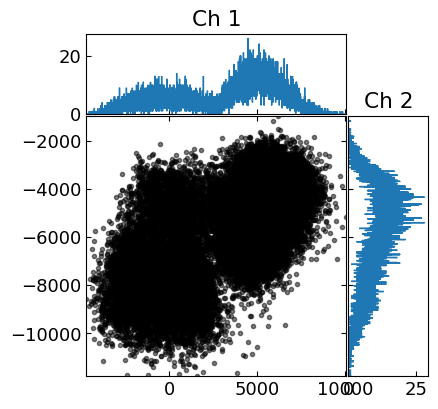

<Figure size 800x800 with 0 Axes>

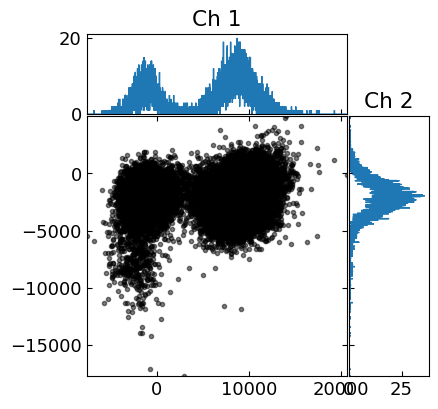

            I1           Q1            I2           Q2
0  5793.601226 -5274.673277  11106.226194 -1143.293030
1  3939.168165 -5773.471150   7445.823787 -3431.179104
2  7451.179653 -3886.056453  -2465.955171  -691.548171
3 -1087.608301 -5518.615698   7524.478324 -2558.662876
4   -83.562740 -6594.135201   3340.591595 -2367.615874
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 4.333209 sec
Captured 9 buffers (2.076983 buffers per sec)
Captured 27648 records (6380.491410 records per sec)
Transferred 452984832 bytes (104537971.2582

<Figure size 800x800 with 0 Axes>

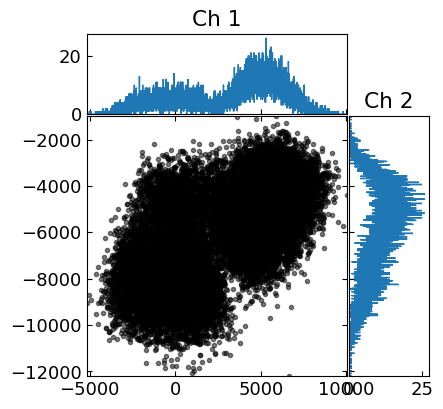

<Figure size 800x800 with 0 Axes>

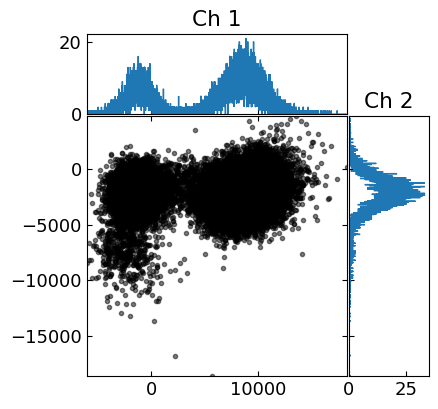

            I1            Q1            I2           Q2
0  6930.689487  -4832.772843    433.087261 -2660.239097
1  2799.789308  -4568.249876   6766.909410 -1620.220617
2  5665.110541  -3688.572304  10013.857519 -1362.908899
3   118.775676 -10162.333145   8580.338556   -47.350299
4  3061.286680  -5328.020871   3757.476671 -3377.923437
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.926826 sec
Captured 9 buffers (2.291928 buffers per sec)
Captured 27648 records (7040.801746 records per sec)
Transferred 452984832 bytes (11535649

<Figure size 800x800 with 0 Axes>

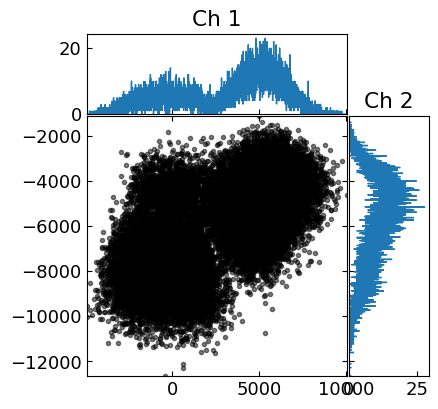

<Figure size 800x800 with 0 Axes>

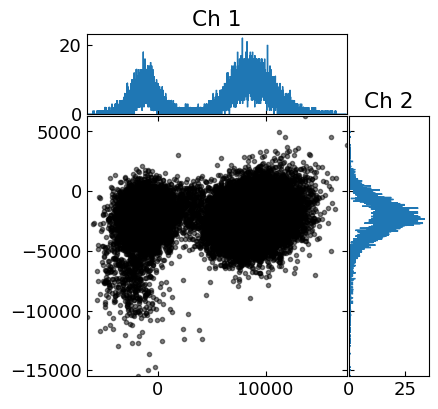

            I1           Q1           I2           Q2
0  4708.562904 -4075.664433  1414.977556 -1061.032777
1  5760.793173 -3724.003047   296.856110 -1976.481882
2  7515.617450 -4269.785121  8910.563912 -2580.635083
3  -183.948164 -6095.756363  7399.403422 -3096.688092
4 -1520.117771 -8266.584106  9290.082506 -3287.234350
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.754410 sec
Captured 9 buffers (2.397181 buffers per sec)
Captured 27648 records (7364.140651 records per sec)
Transferred 452984832 bytes (120654080.427768 byt

<Figure size 800x800 with 0 Axes>

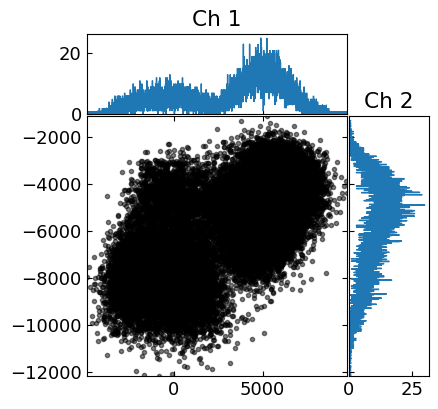

<Figure size 800x800 with 0 Axes>

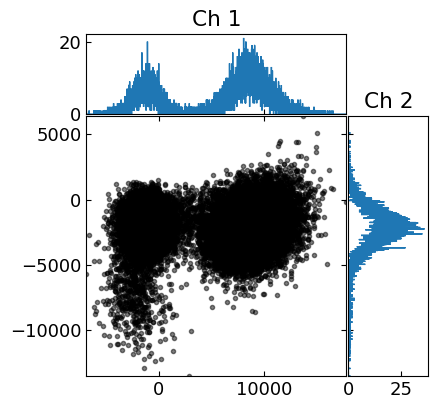

            I1           Q1            I2           Q2
0  8468.093688 -4698.579598   -900.657648 -3359.055369
1  6401.975084 -5713.178499   8645.572697 -1799.593825
2  5558.629728 -4577.930701  -1020.541294 -1612.753756
3  3970.324574 -6229.082334  -2709.415137 -2775.723879
4   126.154557 -6726.657727  10493.898253 -2214.211460
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.927058 sec
Captured 9 buffers (2.291792 buffers per sec)
Captured 27648 records (7040.384118 records per sec)
Transferred 452984832 bytes (115349653.3873

<Figure size 800x800 with 0 Axes>

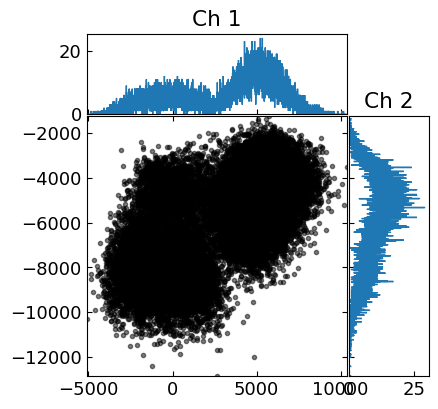

<Figure size 800x800 with 0 Axes>

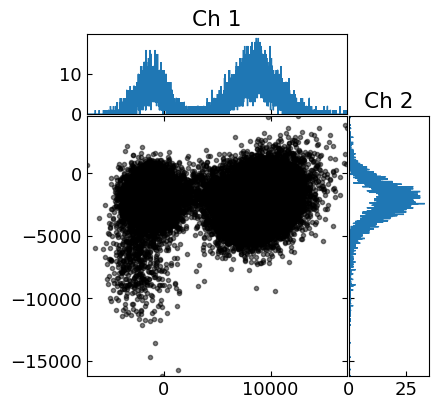

            I1           Q1           I2           Q2
0  1242.751891 -5636.752705 -1128.584488 -1291.176856
1  5062.191951 -2351.424845  9989.933683  -818.348533
2  5211.892051 -2959.314344  7187.761668 -3411.505449
3  1782.368451 -3912.408150  8997.052101 -4774.758093
4 -1138.330951 -8046.235067  8637.413224 -3087.074767
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.761586 sec
Captured 9 buffers (2.392608 buffers per sec)
Captured 27648 records (7350.090789 records per sec)
Transferred 452984832 bytes (120423887.479209 byt

<Figure size 800x800 with 0 Axes>

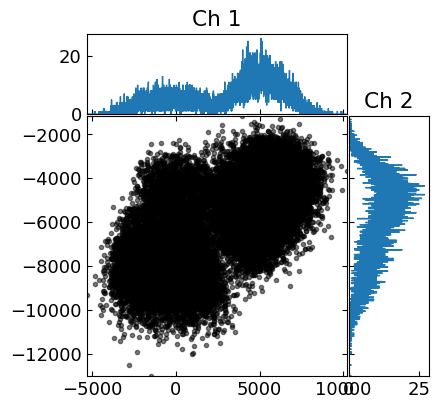

<Figure size 800x800 with 0 Axes>

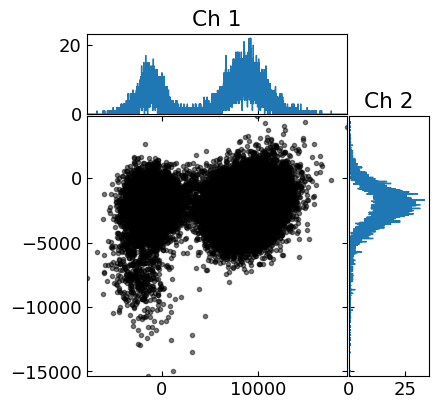

            I1           Q1            I2           Q2
0  7123.195928 -4118.477492  -1162.733084 -4856.335124
1  4401.946516 -3648.880866   9218.032911 -1106.517946
2   -58.608667 -9613.512338  10325.840792 -3392.933096
3 -1363.358132 -9418.248710   7712.827380 -2343.669587
4  4054.337013 -7293.398534   -840.798282 -1699.575310
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.820716 sec
Captured 9 buffers (2.355579 buffers per sec)
Captured 27648 records (7236.340176 records per sec)
Transferred 452984832 bytes (118560197.4482

<Figure size 800x800 with 0 Axes>

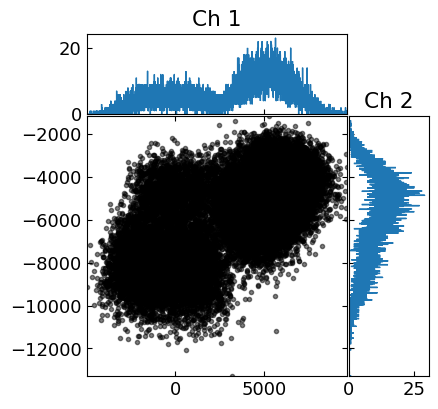

<Figure size 800x800 with 0 Axes>

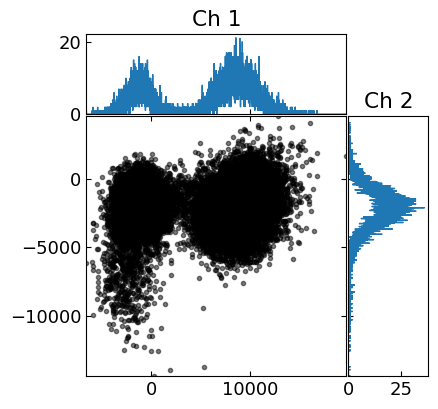

            I1            Q1           I2           Q2
0  2756.696801  -4453.453522  5302.374412 -3129.797251
1  3534.989203  -6979.831205 -1523.346009 -2035.441366
2   671.668681  -7805.277163  8068.351923  -985.073070
3   -24.775737 -10033.559119  8993.735563 -2125.057780
4 -2190.445086  -8745.567543  9839.627356 -3138.039903
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.895348 sec
Captured 9 buffers (2.310448 buffers per sec)
Captured 27648 records (7097.697351 records per sec)
Transferred 452984832 bytes (116288673.3987

<Figure size 800x800 with 0 Axes>

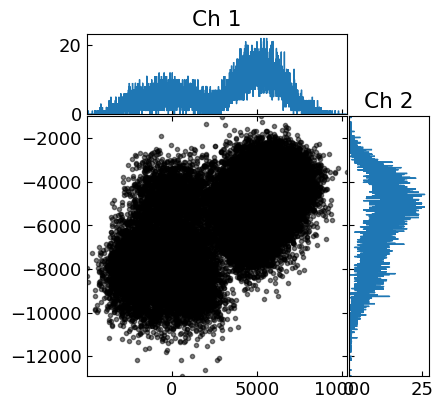

<Figure size 800x800 with 0 Axes>

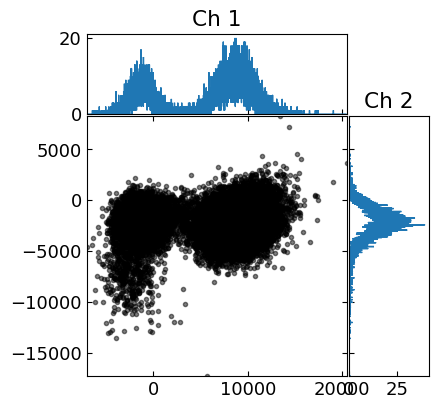

            I1           Q1            I2           Q2
0  4143.074563 -5767.583074  -1566.951212 -1837.035543
1  2332.630919 -4433.058065   9704.653766 -1702.266811
2  6344.750848 -4502.559995  11037.839451 -3810.290523
3  -414.223408 -7584.871418   6803.612629 -2522.592175
4 -1284.570817 -7103.561720   8283.358532 -2638.525615
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.707714 sec
Captured 9 buffers (2.427372 buffers per sec)
Captured 27648 records (7456.886630 records per sec)
Transferred 452984832 bytes (122173630.5400

<Figure size 800x800 with 0 Axes>

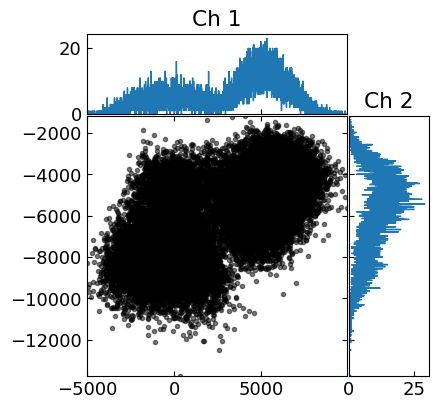

<Figure size 800x800 with 0 Axes>

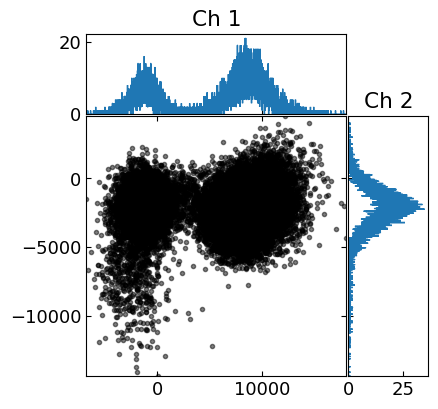

            I1           Q1           I2           Q2
0  4127.214373 -7308.469387 -2714.499554 -1768.861706
1  3999.863651 -5169.541188 -2569.430776 -1716.747793
2  4588.287140 -5760.016495  5999.038786 -2095.315027
3  6242.193545 -3675.927467  -605.996651 -2636.250022
4   311.055289 -6591.785846 -2016.327206 -3829.491681
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.937088 sec
Captured 9 buffers (2.285953 buffers per sec)
Captured 27648 records (7022.449056 records per sec)
Transferred 452984832 bytes (115055805.341240 byt

<Figure size 800x800 with 0 Axes>

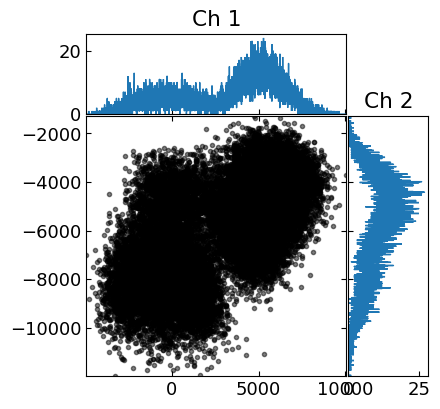

<Figure size 800x800 with 0 Axes>

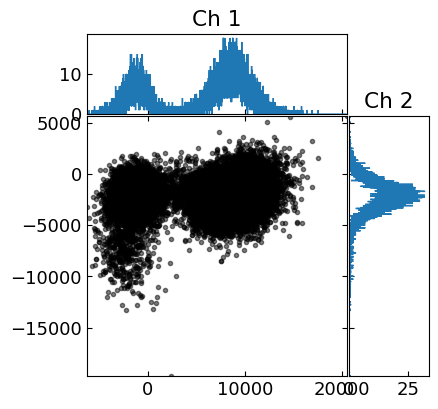

            I1           Q1           I2           Q2
0  5467.331978 -6708.380477 -3445.293595  -802.709762
1  5051.761168 -7568.287004  7007.264069 -1660.809835
2  6380.072251 -3528.926830  -349.915151 -2899.254302
3  -544.703676 -8817.966953  8392.296338 -2397.437100
4 -1734.504428 -7040.887163  8280.074889 -2861.044723
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 4.004034 sec
Captured 9 buffers (2.247733 buffers per sec)
Captured 27648 records (6905.036198 records per sec)
Transferred 452984832 bytes (113132113.065949 byt

<Figure size 800x800 with 0 Axes>

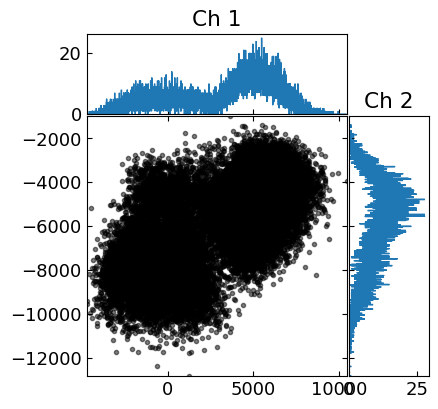

<Figure size 800x800 with 0 Axes>

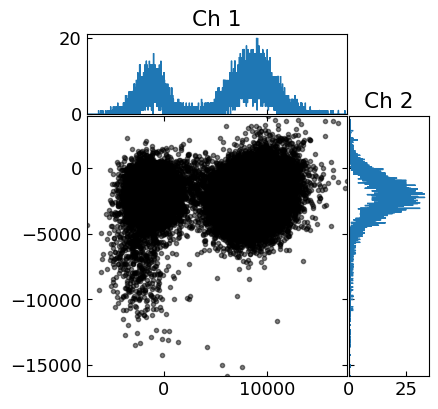

            I1           Q1           I2           Q2
0  5916.665638 -6106.020371 -1899.913153 -2759.116900
1 -1682.236196 -5824.462770 -2415.430744   358.571038
2  3156.142495 -6230.707672  -385.212599  -810.286753
3  1159.053413 -3561.508596  -569.690434 -1733.729155
4  5706.186134 -5306.682423 -1073.271014 -1307.050275
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.793679 sec
Captured 9 buffers (2.372367 buffers per sec)
Captured 27648 records (7287.911885 records per sec)
Transferred 452984832 bytes (119405148.315741 byt

<Figure size 800x800 with 0 Axes>

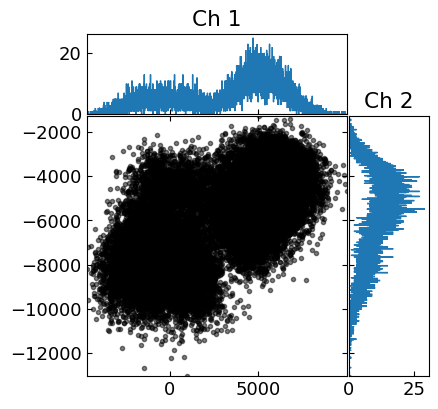

<Figure size 800x800 with 0 Axes>

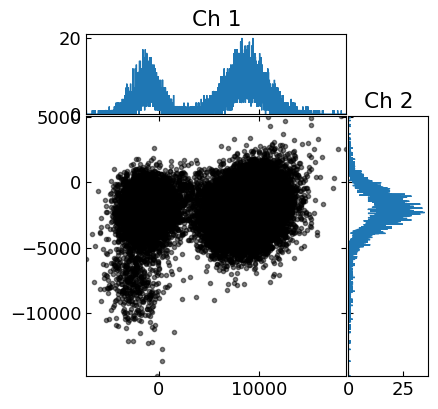

            I1           Q1            I2           Q2
0  4556.248019 -3041.993590    620.726153 -1811.404777
1  4409.417831 -5262.921652  11024.240973 -2264.015697
2  6444.961769 -3064.424741   1511.883827 -4993.121920
3   980.239432 -7075.861220   8599.051079 -1105.891427
4  -906.183499 -8363.837394   9177.114704 -2802.709429
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.894254 sec
Captured 9 buffers (2.311097 buffers per sec)
Captured 27648 records (7099.690602 records per sec)
Transferred 452984832 bytes (116321330.8249

<Figure size 800x800 with 0 Axes>

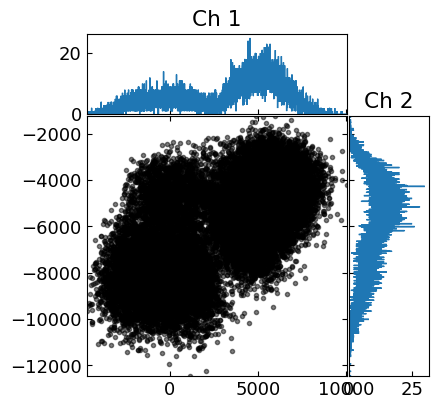

<Figure size 800x800 with 0 Axes>

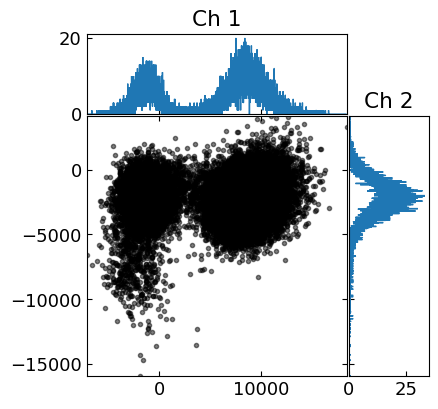

            I1           Q1            I2           Q2
0  5013.217090 -4998.025539   7810.834654 -3358.783999
1  8154.805927 -5416.368084   -582.687791 -1298.515464
2  1211.086843 -9649.146350  10309.672794 -1534.186341
3  3848.037864 -3986.516720   4602.704279 -4097.925520
4  3945.520794 -6431.833880  -3522.206724 -5429.465047
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.739388 sec
Captured 9 buffers (2.406811 buffers per sec)
Captured 27648 records (7393.722801 records per sec)
Transferred 452984832 bytes (121138754.3751

<Figure size 800x800 with 0 Axes>

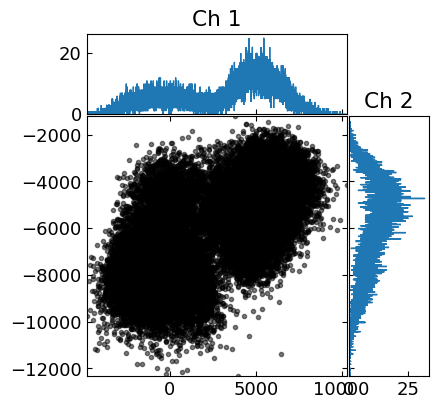

<Figure size 800x800 with 0 Axes>

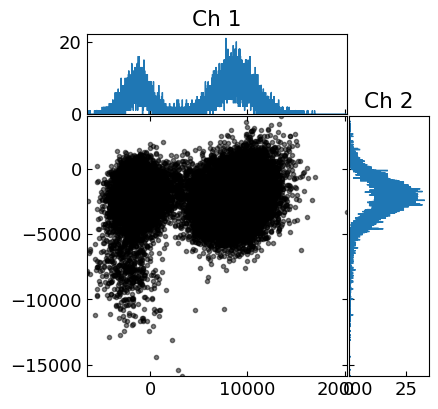

            I1           Q1            I2           Q2
0  5733.833203 -4136.554938   -880.482669 -2045.787278
1  5804.797743 -5426.684233   4783.026315 -2304.091712
2  4761.078415 -6137.169413   5552.356982 -4049.836919
3 -1942.274695 -5336.783045  10014.662875 -2789.382644
4  6912.755608 -4117.757480  -1668.734335 -2722.763977
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.795642 sec
Captured 9 buffers (2.371140 buffers per sec)
Captured 27648 records (7284.143429 records per sec)
Transferred 452984832 bytes (119343405.9483

<Figure size 800x800 with 0 Axes>

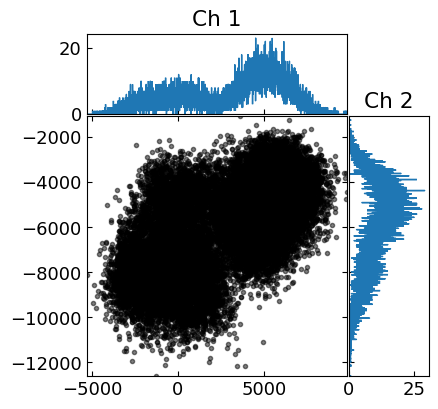

<Figure size 800x800 with 0 Axes>

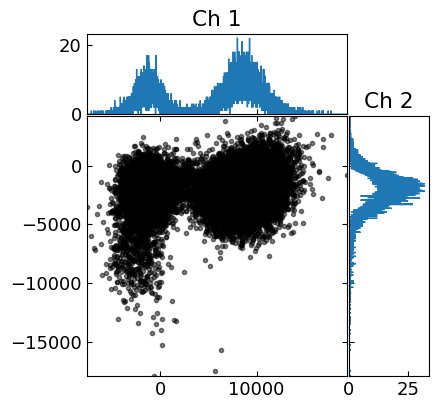

            I1           Q1           I2           Q2
0  6039.438935 -3179.967393  9230.485338 -1459.568724
1  3494.104434 -3800.059172  3048.459757 -3599.722955
2 -2436.048896 -9181.921036  7242.322320 -3071.962443
3  7301.725599 -4369.446826  -252.974841 -2291.054247
4   833.497026 -9854.949519  7896.525124 -2367.179108


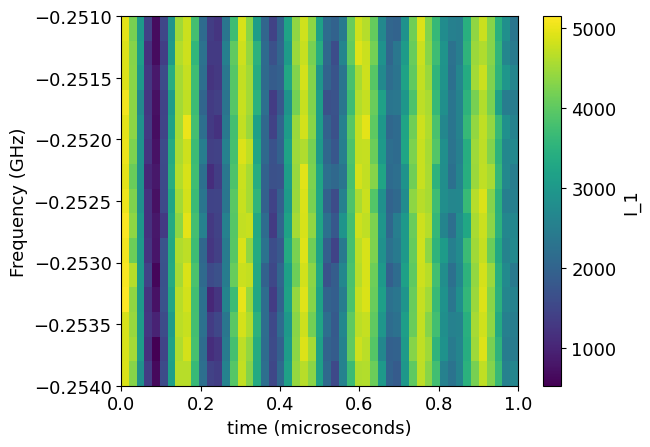

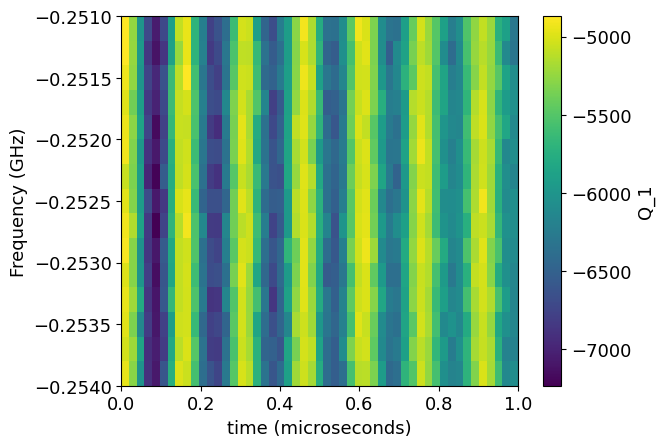

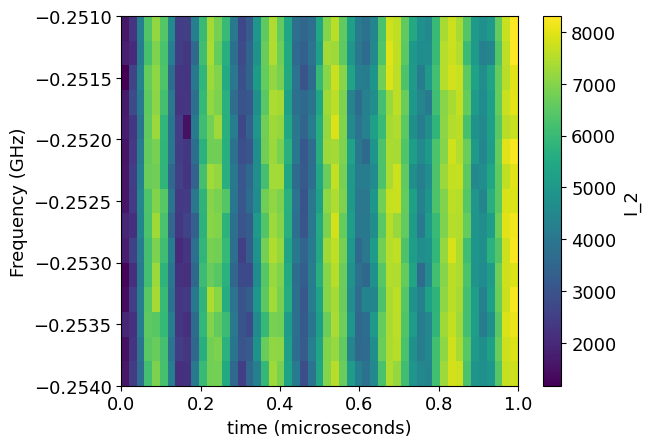

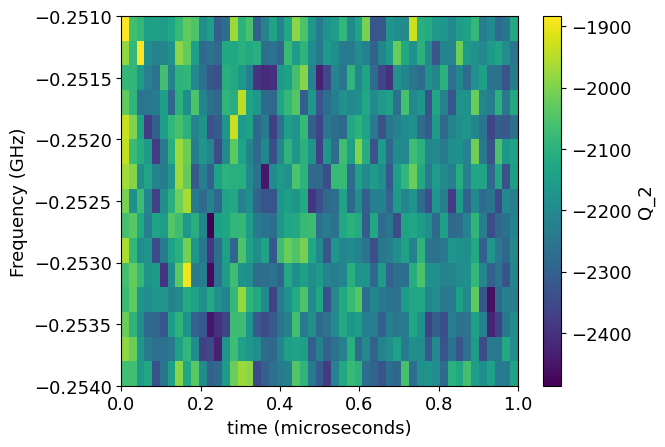

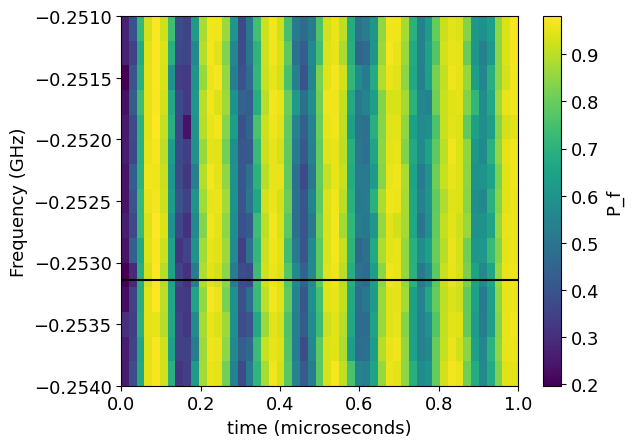

rf= -0.25314285714285717


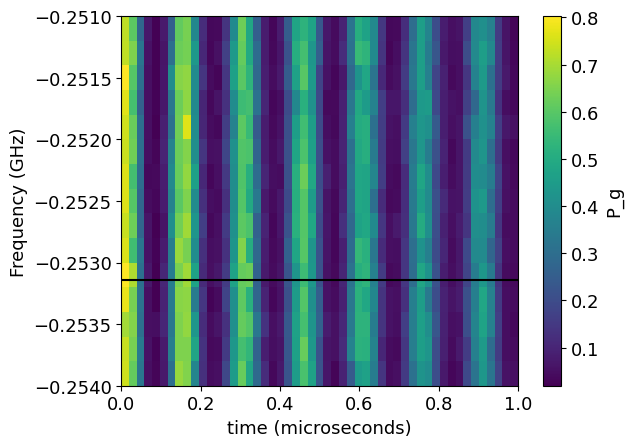

rf= -0.25314285714285717


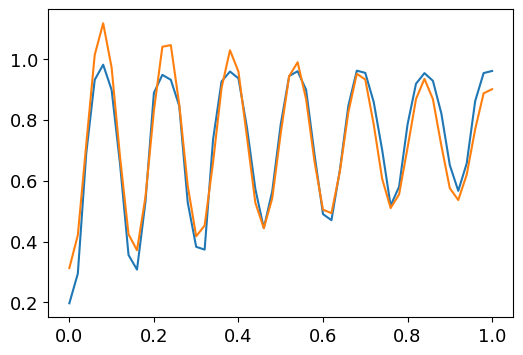



  freq: 6.563719133554502 +/- 0.02625967262037708
 gamma: 0.8349666600102702 +/- 0.1536610731542472
   amp: 0.41679761007788313 +/- 0.0290254855164839
 phase: -95.72058703136453 +/- 4.30903854954042
offset: 0.7275889795686991 +/- 0.009014696653440646
pi_pulse time: 0.076176324706513 +/- 0.02625967262037708
Angular freq(rad/$\mu$ s): 41.241063620403175


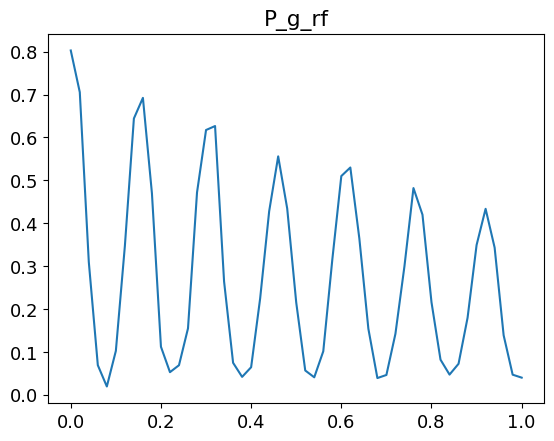

In [38]:
num_steps = 51
reps = 500
sweep_time = 1000
freq_start=-0.251
freq_stop=-0.254
freq_steps= 15
omega_rabi_f,freqPF,P_f_rf,P_g_rf, probability_freq= sweep_ef(freq_start, freq_stop, freq_steps, sweep_time, reps = reps) 

In [36]:
probability_freq

,frequency,Pf,Pe,Pg
0,-0.251000,0.901765,0.054941,0.043294
1,-0.251214,0.900752,0.055122,0.044126
2,-0.251429,0.900825,0.057292,0.041884
3,-0.251643,0.900752,0.057183,0.042065
4,-0.251857,0.898112,0.058232,0.043656
5,-0.252071,0.901476,0.055845,0.042679
6,-0.252286,0.900608,0.056496,0.042896
7,-0.252500,0.900608,0.059462,0.039931
8,-0.252714,0.900861,0.057545,0.041594
9,-0.252929,0.898944,0.057907,0.043150


<Axes: xlabel='frequency', ylabel='Pf'>

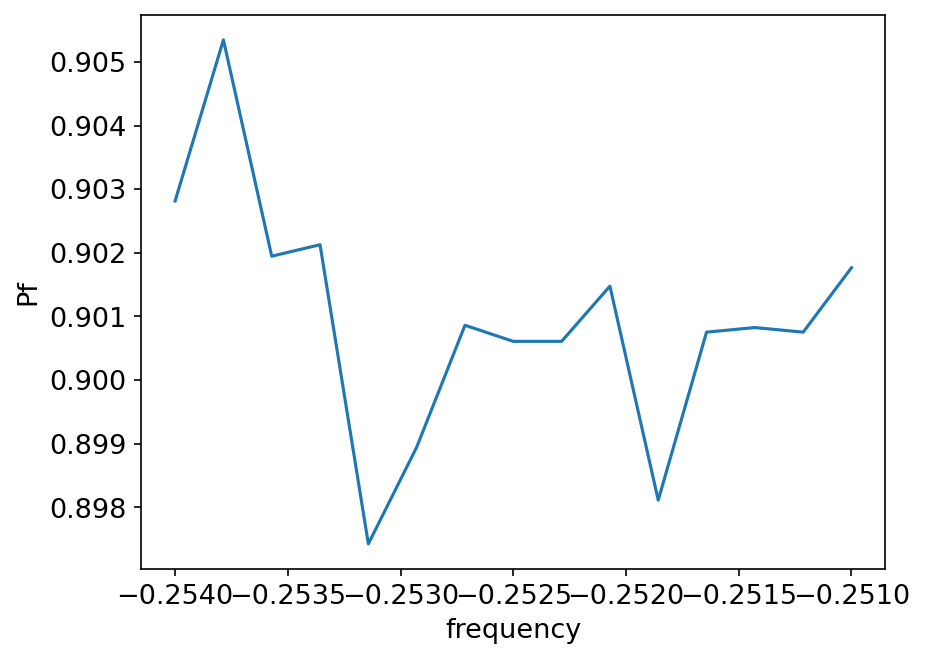

In [37]:
plt.figure(dpi = 150)
sns.lineplot(data = probability_freq, x= "frequency", y = 'Pf')
